## Nota

Para esta primera ejecucion, y la que estara en git, estaba usando la compu, de modo que los tiempos no son los mas optimos

In [20]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import PIL.Image as Image

from skimage import io, color, transform
from skimage.feature import hog

import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report

## Carga de la base (ya guardada)

In [21]:
gray_matrix = np.load('gray_matrix.npy', allow_pickle=True)
hog = np.load('hog.npy', allow_pickle=True)
estados = np.load('estados.npy', allow_pickle=True)
label = np.load('label.npy', allow_pickle=True)

In [22]:
df = pd.DataFrame({'gray_matrix': gray_matrix,'hog': hog,'estados': estados,'label': label})

### Separacion en el df por usar, y el entrenamiento y testeo

In [23]:
dfxusar = df[df['estados'] == 1]
elresto = df[df['estados'] == 0]
dfxusar

,gray_matrix,hog,estados,label
16,"[[175, 166, 185, 198, 202, 213, 212, 209, 210,...","[0.20444939, 0.034390625, 0.026585897, 0.01487...",1,angry
23,"[[26, 29, 30, 35, 45, 60, 108, 145, 161, 161, ...","[0.46974203, 0.15378156, 0.0056655, 0.0, 0.002...",1,angry
30,"[[17, 18, 19, 19, 17, 15, 16, 17, 18, 20, 18, ...","[0.16117984, 0.10060929, 0.12280247, 0.0026138...",1,angry
31,"[[0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 13, 37, ...","[0.17848918, 0.014774916, 0.0, 0.0, 0.0, 0.0, ...",1,angry
45,"[[254, 254, 254, 254, 254, 254, 254, 254, 254,...","[0.025827257, 0.01296422, 0.020755643, 0.0, 0....",1,angry
...,...,...,...,...
35863,"[[9, 38, 69, 99, 86, 102, 111, 105, 65, 58, 64...","[0.23134665, 0.3235038, 0.13396424, 0.05265233...",1,surprise
35869,"[[253, 253, 254, 253, 170, 101, 105, 102, 85, ...","[0.4190711, 0.32569548, 0.0045682807, 0.002312...",1,surprise
35875,"[[252, 247, 146, 93, 94, 89, 99, 94, 93, 83, 9...","[0.32172725, 0.29283354, 0.09000543, 0.0720573...",1,surprise
35878,"[[33, 44, 49, 40, 35, 28, 23, 14, 9, 16, 17, 5...","[0.20763314, 0.31089163, 0.1581842, 0.02511550...",1,surprise


In [24]:
X = np.array(dfxusar['hog'].values.tolist())
y = dfxusar['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19011)

# K-folds y la comparacion inicial

In [25]:
# Definimos el pool de algoritmos de ensamble a evaluar
algos = []
algos.append(('RandomForest', RandomForestClassifier()))
algos.append(('Neural Network',MLPClassifier()))
algos.append(('KNN',KNeighborsClassifier()))

Mas heavy que el resto

In [26]:
%%time
# Evaluamos cada algoritmo en estrategia de 10-fold-CV
results = []
names = []

# genera el particionamiento de 10 folds que seran usados en cada evaluacion
kfold = KFold(n_splits=10, random_state=42, shuffle= True)  # especifica el particionador de datos a 10-folds CV

for algoname, algo in algos:
    cv_results = cross_val_score(algo, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(algoname)
    print("{}: {} ({})".format(algoname, cv_results.mean(), cv_results.std()))

RandomForest: 0.8004344880405325 (0.022969437523252423)
Neural Network: 0.8359549899846824 (0.018344848443026095)
KNN: 0.8299870390008248 (0.01985212932596414)
CPU times: total: 20min 16s
Wall time: 8min 49s


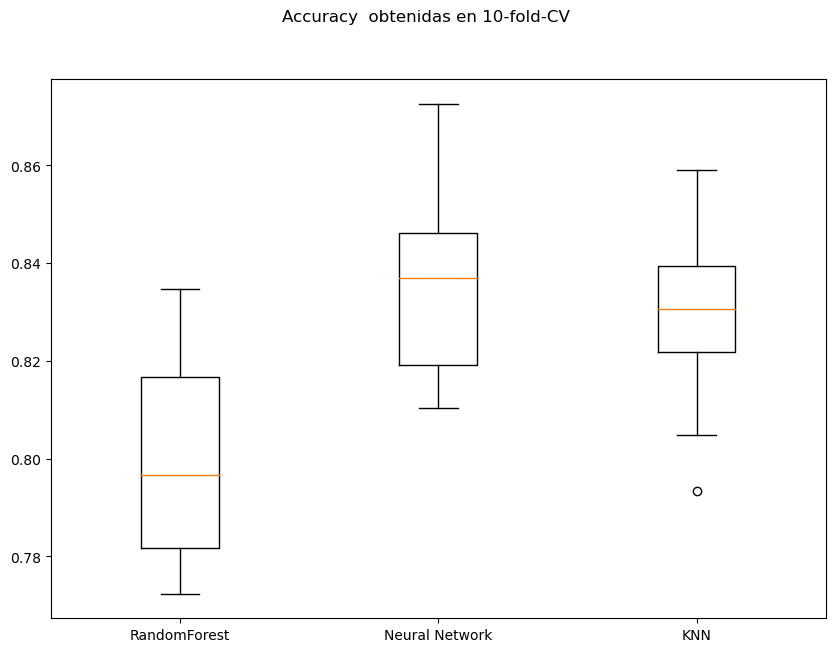

In [27]:
fig = plt.figure(figsize=[10,7])
fig.suptitle('Accuracy  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# RandomForest

In [28]:
%%time
# Crear el modelo
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_classifier.fit(X_train, y_train)

CPU times: total: 33.7 s
Wall time: 37.9 s


RandomForestClassifier(random_state=42)

In [29]:
y_pred_e= rf_classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_e)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_train, y_pred_e))

Precisión del modelo: 1.0
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00       462
     disgust       1.00      1.00      1.00       435
        fear       1.00      1.00      1.00       579
       happy       1.00      1.00      1.00       650
     neutral       1.00      1.00      1.00       622
         sad       1.00      1.00      1.00       467
    surprise       1.00      1.00      1.00       473

    accuracy                           1.00      3688
   macro avg       1.00      1.00      1.00      3688
weighted avg       1.00      1.00      1.00      3688



In [30]:
# Realizar predicciones en el conjunto de prueba
y_pred = rf_classifier.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_test, y_pred))

Precisión del modelo: 0.8039003250270856
              precision    recall  f1-score   support

       angry       0.84      0.68      0.75       101
     disgust       0.81      0.57      0.67       112
        fear       0.75      0.71      0.73       156
       happy       0.83      0.99      0.90       149
     neutral       0.79      0.89      0.84       153
         sad       0.73      0.80      0.76       119
    surprise       0.90      0.90      0.90       133

    accuracy                           0.80       923
   macro avg       0.81      0.79      0.79       923
weighted avg       0.80      0.80      0.80       923



## Primer GridSearch RF

In [37]:
%%time
from sklearn.model_selection import GridSearchCV

# Define el modelo de Random Forest
rf_classifier = RandomForestClassifier()

# Define una cuadrícula de hiperparámetros que deseas explorar
param_grid = {
    'n_estimators': [150,200,250,300],        # Número de árboles en el bosque
    'max_depth': [10,20,30],      # Profundidad máxima de los árboles
    'min_samples_split': [10,20,30],     # Mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [10,20,30]       # Mínimo de muestras requeridas en una hoja
}

# Realiza la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=10,n_jobs=8)
grid_search.fit(X_train, y_train)

# Muestra los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Entrena el modelo con los mejores hiperparámetros en todo el conjunto de entrenamiento
best_rf_classifier = grid_search.best_estimator_
best_rf_classifier.fit(X_train, y_train)

# Evalúa el modelo en el conjunto de prueba
y_pred = best_rf_classifier.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores hiperparámetros: {'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 300}
Precisión del modelo: 0.7963163596966414
              precision    recall  f1-score   support

       angry       0.89      0.69      0.78       101
     disgust       0.83      0.45      0.58       112
        fear       0.77      0.71      0.74       156
       happy       0.79      1.00      0.88       149
     neutral       0.75      0.89      0.81       153
         sad       0.72      0.79      0.76       119
    surprise       0.89      0.95      0.92       133

    accuracy                           0.80       923
   macro avg       0.81      0.78      0.78       923
weighted avg       0.80      0.80      0.79       923

CPU times: total: 2min 29s
Wall time: 54min 49s


## Segundo Grid Search RF

In [ ]:
#'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 300
%%time
from sklearn.model_selection import GridSearchCV

# Define el modelo de Random Forest
rf_classifier = RandomForestClassifier(n_estimators=300)

# Define una cuadrícula de hiperparámetros que deseas explorar
param_grid = {
    'max_depth': [27,28,29,30,31,32,33],      # Profundidad máxima de los árboles
    'min_samples_split': [17,18,19,20,21,22,23],     # Mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [7,8,9,10,11,12,13]       # Mínimo de muestras requeridas en una hoja
}

# Realiza la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=10,n_jobs=8)
grid_search.fit(X_train, y_train)

# Muestra los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Entrena el modelo con los mejores hiperparámetros en todo el conjunto de entrenamiento
best_rf_classifier = grid_search.best_estimator_
best_rf_classifier.fit(X_train, y_train)

# Evalúa el modelo en el conjunto de prueba
y_pred = best_rf_classifier.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_test, y_pred))

# Redes Neuronales

In [31]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=250, random_state=42)
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=250, random_state=42)

In [32]:
y_pred_e= mlp.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_e)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_train, y_pred_e))

Precisión del modelo: 1.0
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00       462
     disgust       1.00      1.00      1.00       435
        fear       1.00      1.00      1.00       579
       happy       1.00      1.00      1.00       650
     neutral       1.00      1.00      1.00       622
         sad       1.00      1.00      1.00       467
    surprise       1.00      1.00      1.00       473

    accuracy                           1.00      3688
   macro avg       1.00      1.00      1.00      3688
weighted avg       1.00      1.00      1.00      3688



In [33]:
# Realizar predicciones en el conjunto de prueba
y_pred = mlp.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_test, y_pred))

Precisión del modelo: 0.828819068255688
              precision    recall  f1-score   support

       angry       0.73      0.74      0.74       101
     disgust       0.65      0.65      0.65       112
        fear       0.79      0.87      0.83       156
       happy       0.97      0.97      0.97       149
     neutral       0.90      0.86      0.88       153
         sad       0.76      0.71      0.74       119
    surprise       0.94      0.90      0.92       133

    accuracy                           0.83       923
   macro avg       0.82      0.82      0.82       923
weighted avg       0.83      0.83      0.83       923



# KNN

In [34]:
knn = KNeighborsClassifier(n_neighbors=5)  # Cambia 5 por el número de vecinos que desees utilizar
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [35]:
y_pred_e= knn.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_e)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_train, y_pred_e))

Precisión del modelo: 0.9088937093275488
              precision    recall  f1-score   support

       angry       0.90      0.93      0.91       462
     disgust       0.86      0.76      0.81       435
        fear       0.91      0.90      0.90       579
       happy       0.92      1.00      0.96       650
     neutral       0.88      0.97      0.92       622
         sad       0.97      0.76      0.85       467
    surprise       0.94      0.98      0.96       473

    accuracy                           0.91      3688
   macro avg       0.91      0.90      0.90      3688
weighted avg       0.91      0.91      0.91      3688



In [36]:
# Realizar predicciones en el conjunto de prueba
y_pred = knn.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')

print(classification_report(y_test, y_pred))

Precisión del modelo: 0.8114842903575298
              precision    recall  f1-score   support

       angry       0.75      0.75      0.75       101
     disgust       0.73      0.49      0.59       112
        fear       0.80      0.81      0.81       156
       happy       0.80      0.99      0.89       149
     neutral       0.80      0.95      0.87       153
         sad       0.95      0.62      0.75       119
    surprise       0.86      0.93      0.90       133

    accuracy                           0.81       923
   macro avg       0.81      0.79      0.79       923
weighted avg       0.81      0.81      0.80       923



# Optimizacion - GridSearch